<img src=docs/tudelft_logo.jpg width=50%>

## Data-driven Design and Analyses of Structures and Materials (3dasm)

## Lecture 10

### Miguel A. Bessa | <a href = "mailto: M.A.Bessa@tudelft.nl">M.A.Bessa@tudelft.nl</a>  | Associate Professor

**What:** A lecture of the "3dasm" course

**Where:** This notebook comes from this [repository](https://github.com/bessagroup/3dasm_course)

**Reference for entire course:** Murphy, Kevin P. *Probabilistic machine learning: an introduction*. MIT press, 2022. Available online [here](https://probml.github.io/pml-book/book1.html)

**How:** We try to follow Murphy's book closely, but the sequence of Chapters and Sections is different. The intention is to use notebooks as an introduction to the topic and Murphy's book as a resource.
* If working offline: Go through this notebook and read the book.
* If attending class in person: listen to me (!) but also go through the notebook in your laptop at the same time. Read the book.
* If attending lectures remotely: listen to me (!) via Zoom and (ideally) use two screens where you have the notebook open in 1 screen and you see the lectures on the other. Read the book.

**Optional reference (the "bible" by the "bishop"... pun intended 😆) :** Bishop, Christopher M. *Pattern recognition and machine learning*. Springer Verlag, 2006.

**References/resources to create this notebook:**
* This simple tutorial is still based on a script I created for this article: https://imechanica.org/node/23957
* It follows from some examples provided by the scikit-learn user guide, which seem to have originated from Mathieu Blondel, Jake Vanderplas, Vincent Dubourg, and Jan Hendrik Metzen.

Apologies in advance if I missed some reference used in this notebook. Please contact me if that is the case, and I will gladly include it here.

## **OPTION 1**. Run this notebook **locally in your computer**:
1. Confirm that you have the 3dasm conda environment (see Lecture 1).

2. Go to the 3dasm_course folder in your computer and pull the last updates of the [repository](https://github.com/bessagroup/3dasm_course):
```
git pull
```
3. Open command window and load jupyter notebook (it will open in your internet browser):
```
conda activate 3dasm
jupyter notebook
```
4. Open notebook of this Lecture.

## **OPTION 2**. Use **Google's Colab** (no installation required, but times out if idle):

1. go to https://colab.research.google.com
2. login
3. File > Open notebook
4. click on Github (no need to login or authorize anything)
5. paste the git link: https://github.com/bessagroup/3dasm_course
6. click search and then click on the notebook for this Lecture.

In [1]:
# Basic plotting tools needed in Python.

import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.style.use("seaborn") # style for plotting that comes from seaborn
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

## Outline for today

* Introduction tutorial on Gaussian Processes (no theory today!)
    - Using Scikit-learn for Gaussian Process Regression (noiseless and noisy datasets)
* Introduction tutorial on Artificial Neural Networks (no theory today!)
    - Using Keras for regression with Artificial Neural Networks (noiseless and noisy datasets)

**Reading material**: This notebook + (GPs in Section 17.3 of book; ANNs in Chapter 13)

## Today's lecture is going to be more practical

Similarly to the previous lecture, we will focus on the practical aspects of two new ML models **without deriving them yet**.

The goal is for you to be able to use these models as *black boxes* and for you to explore them in the Midterm Project assignment (reverse engineering them!).

* So, today we will focus on how to train:
    - **Gaussin Processes** using [scikit-learn](https://scikit-learn.org)
    - **Artificial Neural Networks** (ANNs) using [keras](https://keras.io/) and [tensorflow](https://www.tensorflow.org/)

This way, you can explore these models in the Midterm Project, while in later lectures we will derive these and other models that we use in this course.

## 1. Short tutorial on 1D regression with Gaussian Processes

### Recall the model for linear regression with polynomial basis functions (Lecture 9)

1. Observation distribution:

$$
p(y|x, \mathbf{z}) = \mathcal{N}(y| \mu_{y|z} = f(x;\, \mathbf{z}), \sigma_{y|z}^2 = \sigma^2)
$$

where $f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x)$ and each term is defined by:

* $\mathbf{z} = (\mathbf{w}, \sigma)$ are all the hidden rv's of the model, i.e. the model parameters.
    * the vector $\mathbf{w} = [w_0, w_1, w_2 ..., w_d]^T$ includes the **bias** term $w_0$ and the remaining **weights** $w_i$ with $i=1,..., d$.
    * the vector $\boldsymbol{\phi}(x) = [1, x, x^2, ..., x^d]^T$ includes the **basis functions**, which now correspond to a polynomial of degree $d$.

2. A chosen Prior distribution for each hidden rv of $\mathbf{z}$.

As we will see, Gaussian Processes generalize this model by introducing nonlinear functions and by correlating the entire dataset in a very interesting way.

For now, we will just share how GPs make regression predictions for one-dimensional functions (input $x$ and output $y$). We will follow Görtler et al. (2019) but with a different notation: https://distill.pub/2019/visual-exploration-gaussian-processes

* In Gaussian Processes **each** OUTPUT value $y_i$ in the training data is treated as a random variable that follows a Gaussian distribution:

$\mathbf{y} = \begin{bmatrix}y_1\\ y_2 \\ \vdots\\ y_n \end{bmatrix} \sim \mathcal{N}(\boldsymbol{\mu} , \boldsymbol{\Sigma})$

and where the joint distribution of all the output values $\mathbf{y}$ is also Gaussian (a multivariate Gaussian) defined by a mean vector $\boldsymbol{\mu}$ and a covariance matrix $\boldsymbol{\Sigma}$. The mean is usually assumed to be zero.

We will do the derivations later, but for now we just want to know that the expression for the covariance matrix depends on a nonlinear function called the "covariance function" or "kernel" $k$ that is calculated for **each** pair of INPUT points $x_i$ and $x_j$:

$\Sigma_{ij} = \text{Cov}(y_i,y_j) = k(x_i,x_j)+\alpha_i^2 \delta_{ij}  \quad \Rightarrow \quad \boldsymbol{\Sigma} = \mathbf{K} + \mathbf{R} $

where the kernel $k(x_i,x_j)$ can be many different kinds of functions (with some special properties) and $\alpha_i^2$ is the noise level of $y_i$.


* An example of a kernel function is the RBF: $k(x_i,x_j) = {\color{red}\eta}^2\exp{\left(-\frac{||x_i-x_j||^2}{2{\color{red}\lambda}^2}\right)}$


* Every kernel function has a set of unknown parameters (in red). The RBF has 2 parameters. You can visualize different kernel functions in this figure: https://distill.pub/2019/visual-exploration-gaussian-processes/#MultipleKernels

In the Gaussian Process method, we start by **choosing** a kernel function with an **initial guess** for the values of the parameters. This defines our **prior** information in conjunction with the assumption that the variables follow a multivariate Gaussian distribution:

$\begin{bmatrix}\mathbf{y}\\ y^* \end{bmatrix} \sim \mathcal{N}\left(\mathbf{0} , \, \begin{bmatrix}\mathbf{K}+\mathbf{R} & \mathbf{k}_*\\ \mathbf{k}_*^T & k(x^*,x^* \end{bmatrix}\right)$


As we saw before in the course, Multivariate Gaussian distributions have very interesting properties and it turns out that based on the above assumptions a Gaussian Process predicts both the **mean** and the **variance** of the output point $y^*$ by the following matrix operations:

$\mathbb{E}[y^*]=\mathbf{k}_*^T\left(\mathbf{K}+\mathbf{R}\right)^{-1}\mathbf{y}$

$\text{Cov}[y^*]=k(x^*,x^*)-\mathbf{k}_*^T\left(\mathbf{K}+\mathbf{R}\right)^{-1}\mathbf{k}_*$

* The <span style="color:red">**key concept**</span> is that the prediction of the mean and variance of the new point $y^*$ depends on the values of the parameters of the kernel function (which are **UNKNOWN**).


* However, despite the fact that we don't know the parameters of the kernel function, they can be obtained by **Bayesian inference**.

As we saw previousy, Bayesian inference is possible by using Bayes rule to find the **posterior** information. This involves doing Marginalization and Conditioning. We will do this in the next lectures.

Today, we are focusing on learning how to do Gaussian Process regression for one-dimensional datasets.

Let's start with a noiseless case.

In [2]:
from sklearn.model_selection import train_test_split

# Function to "learn"
def f(x):
    return x * np.sin(x)

n_data = 50 # number of points in our dataset
testset_ratio = 0.90 # ratio of test set points from the dataset
x_data = np.linspace(0, 10, n_data) # uniformly spaced points
y_data = f(x_data) # function values at x_data

X_data = np.reshape(x_data,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train, X_test, y_train, y_test = train_test_split(X_data,
                                    y_data, test_size=testset_ratio,
                                    random_state=seed)

x_train = X_train.ravel() # just for plotting later
x_test = X_test.ravel() # just for plotting later

print("Here's a print of X_train:\n", X_train)

Here's a print of X_train:
 [[6.12244898]
 [8.57142857]
 [7.14285714]
 [2.85714286]
 [8.97959184]]


### Gaussian Process Regression (GPR) for noiseless datasets

Let's use the RBF kernel for our predictions:

$$
k(x_i,x_j) = {\color{red}\eta}^2\exp{\left(-\frac{||x_i-x_j||^2}{2{\color{red}\lambda}^2}\right)}
$$

with an initial guess for the parameters as: $\eta = 1$ and $\lambda = 10$.

In [3]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel

# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the standard RBF kernel
#kernel = 1.0 * RBF(10, (1e-2, 1e2)) # Same kernel as above (scikit-learn assumes constant variance if you just
                                     # write RBF without the constant kernel or without multiplying by 1.0)

# Other examples of kernels:
#kernel = ExpSineSquared(length_scale=3.0, periodicity=3.14,
#                       length_scale_bounds=(0.1, 10.0),
#                       periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))
#kernel = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)
                
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, n_restarts_optimizer=20) # using a small alpha

# Fit to data to determine parameters
gp_model.fit(X_train, y_train)

# Make the prediction on the entire dataset (for plotting)
y_data_pred, sigma_data = gp_model.predict(X_data, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred, sigma = gp_model.predict(X_test, return_std=True) # also output the uncertainty (std)

In [4]:
# Plot the function, the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_data, y_data, 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # function to learn

ax1.plot(x_train, y_train, 'ro', markersize=6, label="training points") # noiseless data

ax1.plot(x_test, y_test, 'kX', markersize=6, label="testing points") # Plot test points

ax1.plot(x_data, y_data_pred, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_data, x_data[::-1]]),
         np.concatenate([y_data_pred - 1.9600 * sigma_data,
                        (y_data_pred + 1.9600 * sigma_data)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
ax1.set_xlabel('$x$')
ax1.set_ylabel('$f(x)$')
ax1.set_title("Posterior kernel: %s"
              % gp_model.kernel_, fontsize=12) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left')
plt.close(fig1) # close the plot to see it in next cell

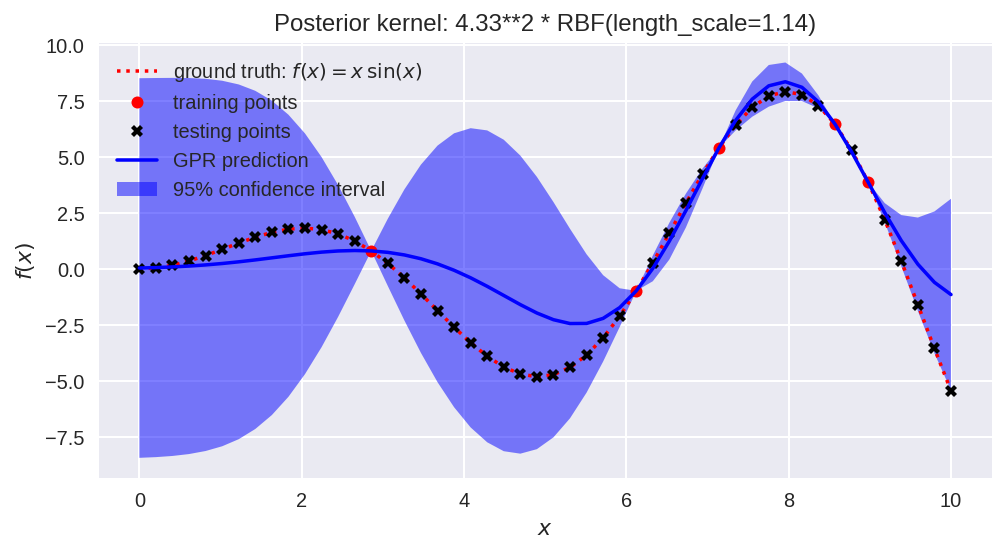

In [5]:
fig1 # plot figure.

### Exercise 1

Fit a polynomial of degree 4 (like we did last class) and compute the error metrics for that model as well as the above mentioned Gaussian process.

In [6]:
# Write your code for Exercise 1:

# until here.

Gaussian Process Regression approximates the function much better...

* However, note that the **choice of kernel** used in GPR affects the quality of the prediction.

### Gaussian Process regression for noisy datasets

Let's recreate the noisy dataset from $f(x)=x\sin{x}$, as we did in Lecture 9:

In [7]:
# Now let's also create the noisy dataset:
random_std = 0.5 + 1.0 * np.random.random(y_data.shape) # np.random.random returns random number between [0.0, 1.0)
noise = np.random.normal(0, random_std) # sample vector from Gaussians with random standard deviation
y_noisy_data = y_data + noise # Perturb every y_data point with Gaussian noise

# Pair up points with their associated noise level (because of train_test_split):
Y_noisy_data = np.column_stack((y_noisy_data,noise))

# Split into 10% training points and the rest for testing:
X_train, X_test, Y_noisy_train, Y_noisy_test = train_test_split(X_data,
                                    Y_noisy_data, test_size=testset_ratio,
                                    random_state=seed) # "noisy_train" is a great name for a variable, hein?
# NOTE: since we are using the same seed and we do train_test_split on the same X_data and y_noisy_data is
#       just y_data + noise, we are splitting the dataset exactly in the same way! This is nice because we
#       want to keep the comparison as fair as possible.

# Finally, for plotting purposes, let's convert the 2D arrays into 1D arrays (vectors):
x_train = X_train.ravel()
x_test = X_test.ravel()
y_noisy_train = Y_noisy_train[:,0]
noise_train = Y_noisy_train[:,1]
y_noisy_test = Y_noisy_test[:,0]
noise_test = Y_noisy_test[:,1]

print("Note that X_train and X_test are the same data that we used for the noiseless case.")
print("Here's a print of X_train:\n", X_train)

Note that X_train and X_test are the same data that we used for the noiseless case.
Here's a print of X_train:
 [[6.12244898]
 [8.57142857]
 [7.14285714]
 [2.85714286]
 [8.97959184]]


In [8]:
# Instanciate a Gaussian Process model
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

# Fitting for noisy data, if we have access to the uncertainty at the training points (usually we don't!), then
# we can include the noise level at the alpha parameter
gp_model = GaussianProcessRegressor(kernel=kernel, alpha=noise_train**2, n_restarts_optimizer=5)

# Fit to data to determine the parameters of the model
gp_model.fit(X_train, y_noisy_train)

# Make the predictions
y_noisy_pred, sigma_noisy = gp_model.predict(X_test, return_std=True) # predictions including uncertainty (std)
y_noisy_data_pred, sigma_noisy_data = gp_model.predict(X_data, return_std=True) # for plotting

# Plot the function, the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots() # This opens a new figure

ax1.plot(x_data, f(x_data), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # function to learn

plt.errorbar(x_train, y_noisy_train, noise_train, fmt='ro', markersize=6, label=u'training points inc. uncertainty')

plt.errorbar(x_test, y_noisy_test, noise_test, fmt='kX', markersize=6, label=u'testing points inc. uncertainty')

plt.plot(x_data, y_noisy_data_pred, 'b-', label="GPR prediction")
plt.fill(np.concatenate([x_data, x_data[::-1]]),
         np.concatenate([y_noisy_data_pred - 1.9600 * sigma_noisy_data,
                        (y_noisy_data_pred + 1.9600 * sigma_noisy_data)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.ylim(-20, 20)
plt.legend(loc='upper left')
plt.close(fig1)

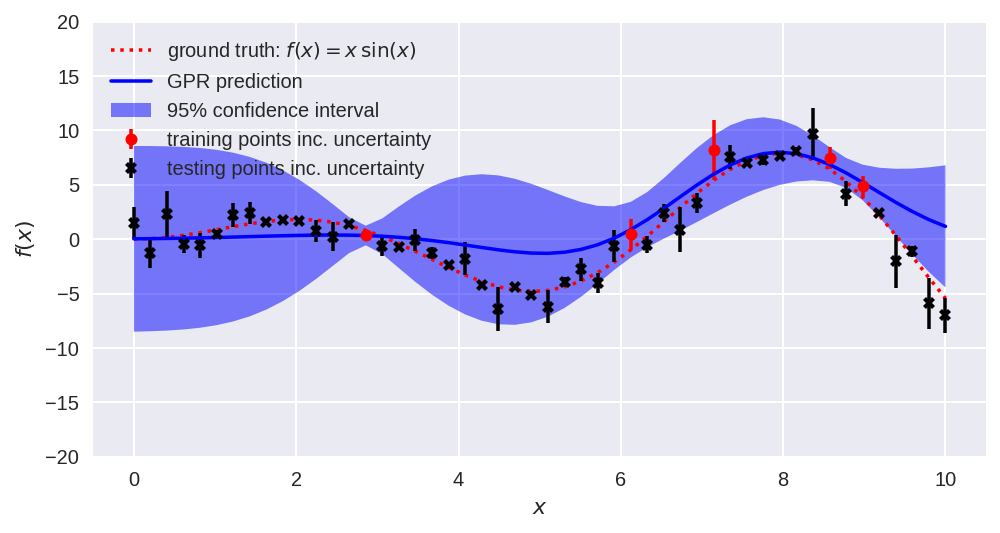

In [9]:
fig1 # plot figure.

### Exercise 2

Fit a polynomial of degree 4 (like we did last class) and compute the error metrics for that model as well as the above mentioned Gaussian process.

In [10]:
# Exercise 2.

# until here.

Well done...

In the Midterm Project you will empirically explore Gaussian Processes.

## 2. Short tutorial on 1D regression with Artificial Neural Networks

ANNs for regression are not that different when compared to linear regression.

Consider again the observation distribution as we wrote it in the beginning of the lecture.

$$
p(y|x, \mathbf{z}) = \mathcal{N}(y| \mu_{y|z} = f(x;\, \mathbf{z}), \sigma_{y|z}^2 = \sigma^2)
$$

But now, instead of modeling the mean of the distribution using polynomial basis functions by $f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x)$, consider a simple extension where the **basis functions also have their own parameters**:

$$
f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x;\, \mathbf{z}_2)
$$

where $\mathbf{z} = (\mathbf{z}_1,\, \mathbf{z}_2)$ and $\mathbf{z}_1 = (\mathbf{W},\, \mathbf{b})$ are all the parameters of the model.

Instead of stopping here,

$$
f(x;\, \mathbf{z}) = \mathbf{w}^T \boldsymbol{\phi}(x;\, \mathbf{z}_2)
$$

we can also repeat this recursively $L$ times to create more complex transformations:

$$
f(x;\, \mathbf{z}) = f_L\left( f_{L-1}\left(\cdots \left(f_1\left(x\right)\right)\cdots\right)\right)
$$

where $f_l(x) = f(x;\, \mathbf{z}_l)$ is the function at layer $l$ of our recursive transformation.

This is the key idea behind **deep neural networks**.

* Confused?

Let's try to see this for a very simple case. Consider again the observation distribution:

$$
p(y|x, \mathbf{z}) = \mathcal{N}(y| \mu_{y|z} = f(x;\, \mathbf{z}), \sigma_{y|z}^2 = \sigma^2)
$$

The simplest extension comes from using a nonlinear function $f_1$ acting on our well-known linear model:

$$
\mu_{y|z} = f(x;\, \mathbf{z}) = f_1\left( \mathbf{w}^T \boldsymbol{\phi}(x) \right) = f_1\left( f_0 \left(x; \mathbf{z}_0 \right) \right) = f_1\left(b_0 + w_0 x\right)
$$

where we are calling our linear regression model as $f_0 \left(x; \mathbf{z}_0 \right)$.

So, our model for the mean of the observation distribution becomes:

$$
\mu_{y|z} = f_1\left( b_0 + w_0 x \right)
$$

But why stop here?

Why not introducing more parameters?

$$
\mu_{y|z} = b_1 + w_1 f_1\left( b_0 + w_0 x \right)
$$

But why stop here?

What if we apply another nonlinear function $f_2$?

$$
\mu_{y|z} = f_2\left(b_1 + w_1 f_1\left( b_0 + w_0 x \right)\right)
$$

What about doing this recursively $L$ times to create more complex transformations?

$$
f(x;\, \mathbf{z}) = f_L\left( f_{L-1}\left(\cdots \left(f_1\left(b_0 + w_0 x\right)\right)\cdots\right)\right)
$$

This is one of the simplest examples of an Artificial Neural Network architecture called feedforward architecture.

We will look into this model carefully in a few lectures.

For now, I just want to draw a schematic so that you understand the number of parameters that starts appearing!

* Draw on the board a feedforward ANN with 2 hidden layers for 1D case.
    * First hidden layer with 3 neurons and second hidden layer with 2 neurons.

Two examples of these nonlinear functions.


<div>
<img style="float: left"; src=docs/nonlin_fn.png width=500px></div>

In [11]:
# -----------------------------------------------------------
# Neural Networks example
# KERAS:
from tensorflow import keras # fast library for ANNs
from keras.models import Sequential # to create a feedforward neural network
from keras.layers.core import Dense # to create a feedforward neural network with dense layers
from keras.wrappers.scikit_learn import KerasRegressor # a new version will use scikeras
from keras.callbacks import EarlyStopping # a strategy for complexity control
from sklearn.preprocessing import StandardScaler # standardize the dataset with scikit-learn
#from sklearn.model_selection import GridSearchCV # simple (brute force) approach to find better hyperparameters.
#
# Function to create the ANN model (in this case we are creating )
def create_ANN(input_dimensions=1, # number of input variables
               neurons1=3, # number of neurons in first hidden layer
               neurons2=2, # number of neurons in second hidden layer
               activation='relu', # activation function
               optimizer='adam'): # optimization algorithm to compute the weights and biases
    # create model
    model = Sequential() # Feedforward architecture
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    model.add(Dense(1)) # output layer with just one neuron because we have only one output (1D problem!)
    model.compile(loss='mse', # error metric to measure our NLL (loss)
                  optimizer=optimizer)
    return model
# -----------------------------------------------------------------------------
#
# Standardizing your dataset is usually a good practice and can be important for ANNs:
scaler = StandardScaler().fit(X_train) # Check scikit-learn to see what this does!
#
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)
X_data_scaled=scaler.transform(X_data)
#

# Now create your first ANN model!
neurons1=200 # number of neurons for the first hidden layer
neurons2=10 # number of neurons for the second hidden layer
batch_size = len(X_train) # considering the entire dataset for updating the weights and biases in each epoch
ANN_model = KerasRegressor(build_fn=create_ANN, neurons1=neurons1, neurons2=neurons2,
                           batch_size=batch_size, epochs=150, optimizer='adam',
                           validation_data=(scaler.transform(X_test), y_test))

/tmp/ipykernel_157997/2446095615.py:40: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  ANN_model = KerasRegressor(build_fn=create_ANN, neurons1=neurons1, neurons2=neurons2,


In [12]:
# Now that we created our first ANN model, let's fit it to our (scaled) dataset!
history = ANN_model.fit(X_train_scaled, y_train)

2022-03-10 15:36:54.936052: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-10 15:36:55.446174: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4 MB memory:  -> device: 0, name: Quadro M2000, pci bus id: 0000:03:00.0, compute capability: 5.2


Epoch 1/150
1/1 [==============================] - 1s 704ms/step - loss: 17.9853 - val_loss: 14.0081
Epoch 2/150
1/1 [==============================] - 0s 32ms/step - loss: 17.8202 - val_loss: 13.9711
Epoch 3/150
1/1 [==============================] - 0s 35ms/step - loss: 17.6547 - val_loss: 13.9372
Epoch 4/150
1/1 [==============================] - 0s 32ms/step - loss: 17.5073 - val_loss: 13.9052
Epoch 5/150
1/1 [==============================] - 0s 31ms/step - loss: 17.3714 - val_loss: 13.8779
Epoch 6/150
1/1 [==============================] - 0s 29ms/step - loss: 17.2365 - val_loss: 13.8620
Epoch 7/150
1/1 [==============================] - 0s 32ms/step - loss: 17.1110 - val_loss: 13.8510
Epoch 8/150
1/1 [==============================] - 0s 37ms/step - loss: 17.0357 - val_loss: 13.8359
Epoch 9/150
1/1 [==============================] - 0s 31ms/step - loss: 16.9661 - val_loss: 13.8279
Epoch 10/150
1/1 [==============================] - 0s 35ms/step - loss: 16.8965 - val_loss: 13.817

1/1 [==============================] - 0s 32ms/step - loss: 8.7710 - val_loss: 12.3053
Epoch 83/150
1/1 [==============================] - 0s 31ms/step - loss: 8.6124 - val_loss: 12.2981
Epoch 84/150
1/1 [==============================] - 0s 30ms/step - loss: 8.4544 - val_loss: 12.2890
Epoch 85/150
1/1 [==============================] - 0s 32ms/step - loss: 8.2961 - val_loss: 12.2790
Epoch 86/150
1/1 [==============================] - 0s 32ms/step - loss: 8.1376 - val_loss: 12.2712
Epoch 87/150
1/1 [==============================] - 0s 35ms/step - loss: 7.9789 - val_loss: 12.2649
Epoch 88/150
1/1 [==============================] - 0s 35ms/step - loss: 7.8202 - val_loss: 12.2602
Epoch 89/150
1/1 [==============================] - 0s 33ms/step - loss: 7.6633 - val_loss: 12.2568
Epoch 90/150
1/1 [==============================] - 0s 35ms/step - loss: 7.5038 - val_loss: 12.2540
Epoch 91/150
1/1 [==============================] - 0s 31ms/step - loss: 7.3461 - val_loss: 12.2517
Epoch 92/150


In [13]:
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)
# Create a plot for the loss history
ax1_ANN.plot(history.history['loss']) # plot training loss
ax1_ANN.plot(history.history['val_loss']) # plot testing loss
ax1_ANN.set_title('Training and testing loss', fontsize=20)
ax1_ANN.set_ylabel('loss', fontsize=20)
ax1_ANN.set_xlabel('epoch', fontsize=20)
ax1_ANN.legend(['training', 'testing'], loc='upper right', fontsize=20)

# Create a plot for the ANN prediction
ax2_ANN.plot(x_data, f(x_data), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # show ground truth function
ax2_ANN.plot(x_train, y_train, 'ro', markersize=6, label="training points") # show training data
ax2_ANN.plot(x_test, y_test, 'kx', markersize=6, label="testing points") # show testing data

y_pred = history.model.predict(X_data_scaled) # predict all data points with ANN

ax2_ANN.plot(x_data, y_pred, 'b-', label="Neural Network prediction") # plot prediction
ax2_ANN.set_title(r'NN with '+str(neurons1)+' neurons in the 1st hidden layer, and '+str(neurons2)+' in the 2nd',
                 fontsize=20)
ax2_ANN.set_xlabel('$x$', fontsize=20)
ax2_ANN.set_ylabel('$f(x)$', fontsize=20)
ax2_ANN.legend(loc='upper left', fontsize=20)

# Create figure with specified size
fig_ANN.set_size_inches(25, 10)
plt.close(fig_ANN) # do not plot the figure now. We will show it in the next cell

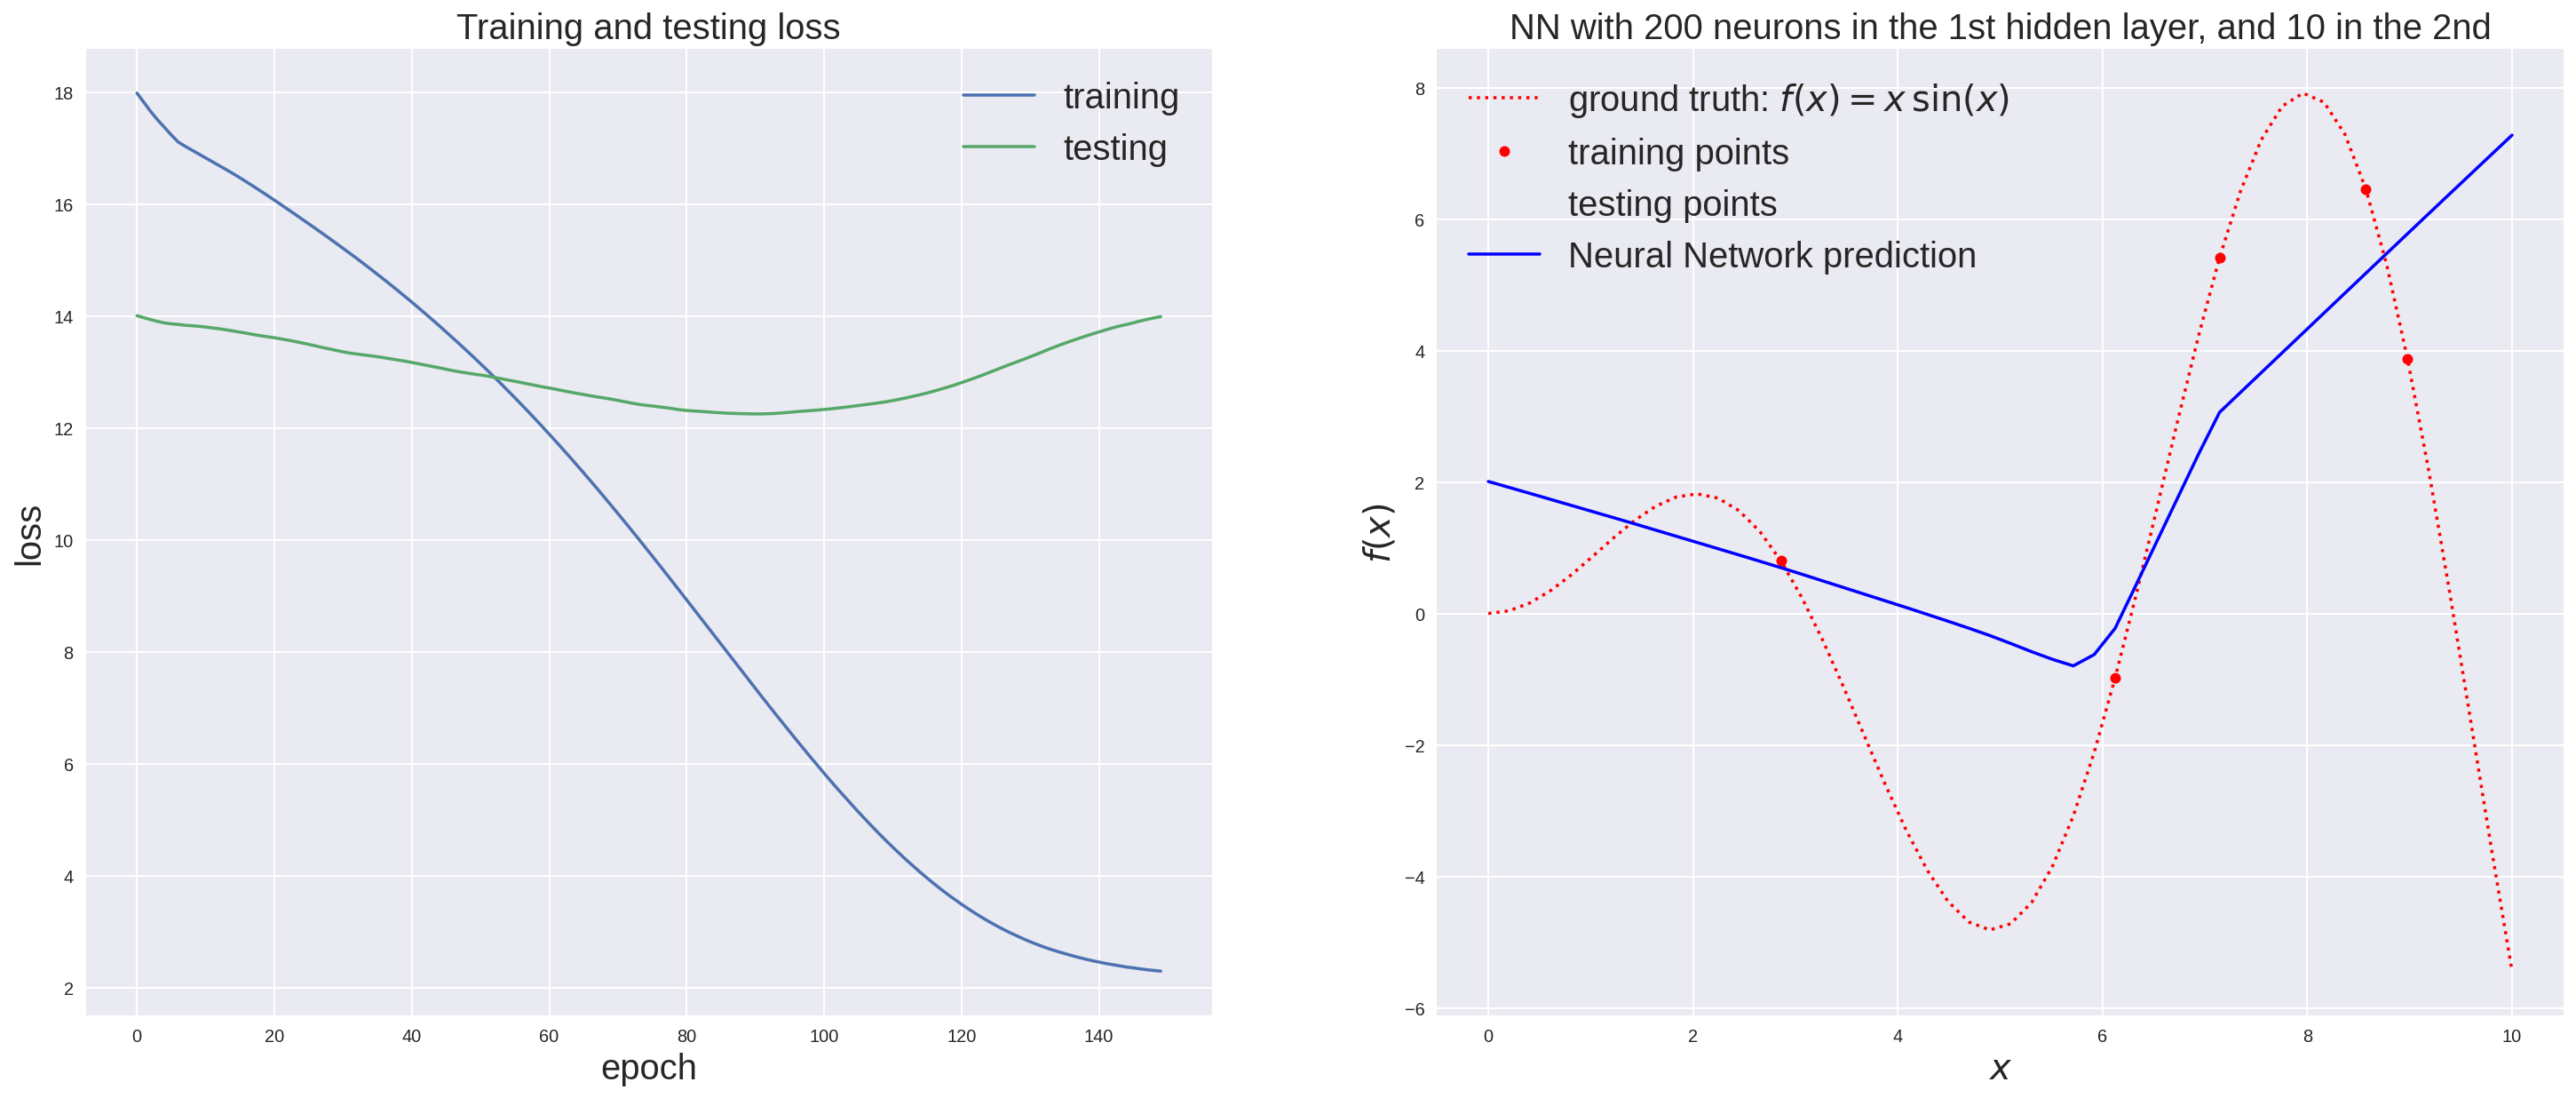

In [14]:
fig_ANN # show figure now.

Not the most amazing model you have ever seen, right?

* Try again but now using 200 neurons for the first hidden layer and 10 for the second hidden layer.
    - spoiler alert: a bit better, but far from amazing...

It's possible to try to find better hyperparameters (and ANNs have many!).

Below is a simple code to do this by "brute force" in a procedure called grid search.

There are some Bonus questions in the Midterm Project where you can use this strategy to find better hyperparameters...

In [15]:
# -----------------------------------------------------------
# Neural Networks example
# KERAS:
from tensorflow import keras # fast library for ANNs
from keras.models import Sequential # to create a feedforward neural network
from keras.layers.core import Dense # to create a feedforward neural network with dense layers
from keras.wrappers.scikit_learn import KerasRegressor # a new version will use scikeras
from keras.callbacks import EarlyStopping # a strategy for complexity control
from sklearn.preprocessing import StandardScaler # standardize the dataset with scikit-learn
from sklearn.model_selection import GridSearchCV # simple (brute force) approach to find better hyperparameters.
#
# Function to create the ANN model (in this case we are creating )
def create_model(input_dimensions=1,neurons1=10,neurons2=10,neurons3=10,neurons4=10,
                 activation='relu',optimizer='adam'):
    # create model
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, activation=activation)) # first hidden layer
    model.add(Dense(neurons2, activation=activation)) # second hidden layer
    #model.add(Dense(neurons3, activation=activation)) # UNCOMMEND If you want a third hidden layer
    #model.add(Dense(neurons4, activation=activation)) # UNCOMMENT if you want a fourth hidden layer, etc.
    model.add(Dense(1)) # output layer with just one neuron (we only have one output)
    model.compile(loss='mse', optimizer=optimizer) # choose error metric and optimizer.
    return model
# -----------------------------------------------------------------------------
#
# create model
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.0, patience=30, mode='min')

# define the grid search parameters
neurons1 = [5,20,200] # number of neurons in hidden layer 1
#neurons1 = [5] # number of neurons in hidden layer 1
#neurons2 = [5,10] # number of neurons in hidden layer 2 (if present; uncomment in create_model function)
neurons2 = [5] # number of neurons in hidden layer 2 (if present; uncomment in create_model function)
neurons3 = [10] # number of neurons in hidden layer 3 (if present; uncomment in create_model function)
neurons4 = [10] # number of neurons in hidden layer 4 (if present; uncomment in create_model function)
#
batch_size = [len(X_train)] # here considering batch size as large as the training data.
#
epochs = [1000]
#
optimizer = ['adam']
#optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
#init_mode = ['uniform', 'lecun_uniform', 'normal', 'orthogonal', 'zero', 'one', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']    
#
param_grid = dict(batch_size=batch_size, epochs=epochs,neurons1=neurons1,
                  neurons2=neurons2,
                  #neurons3=neurons3,neurons4=neurons4, # commented out because I am not using them
                  optimizer=optimizer)
NN_model = KerasRegressor(build_fn=create_model)
grid = GridSearchCV(estimator=NN_model, param_grid=param_grid, n_jobs=1, cv=3)
grid_result = grid.fit(X_train_scaled, y_train, callbacks=[early_stopping], validation_data=(scaler.transform(X_test), y_test))
history = grid_result.best_estimator_.fit(X_train_scaled, y_train,callbacks=[early_stopping], validation_data=(scaler.transform(X_test), y_test))
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

/tmp/ipykernel_157997/1873086816.py:49: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  NN_model = KerasRegressor(build_fn=create_model)


Epoch 1/1000
1/1 [==============================] - 0s 345ms/step - loss: 17.8575 - val_loss: 14.6810
Epoch 2/1000
1/1 [==============================] - 0s 33ms/step - loss: 17.8142 - val_loss: 14.6729
Epoch 3/1000
1/1 [==============================] - 0s 31ms/step - loss: 17.7711 - val_loss: 14.6650
Epoch 4/1000
1/1 [==============================] - 0s 34ms/step - loss: 17.7282 - val_loss: 14.6574
Epoch 5/1000
1/1 [==============================] - 0s 34ms/step - loss: 17.6856 - val_loss: 14.6499
Epoch 6/1000
1/1 [==============================] - 0s 34ms/step - loss: 17.6433 - val_loss: 14.6426
Epoch 7/1000
1/1 [==============================] - 0s 31ms/step - loss: 17.6012 - val_loss: 14.6356
Epoch 8/1000
1/1 [==============================] - 0s 33ms/step - loss: 17.5594 - val_loss: 14.6287
Epoch 9/1000
1/1 [==============================] - 0s 33ms/step - loss: 17.5179 - val_loss: 14.6221
Epoch 10/1000
1/1 [==============================] - 0s 38ms/step - loss: 17.4766 - val_lo

1/1 [==============================] - 0s 31ms/step - loss: 15.3768 - val_loss: 14.4538
Epoch 82/1000
1/1 [==============================] - 0s 36ms/step - loss: 15.3597 - val_loss: 14.4540
Epoch 83/1000
1/1 [==============================] - 0s 36ms/step - loss: 15.3432 - val_loss: 14.4544
Epoch 84/1000
1/1 [==============================] - 0s 35ms/step - loss: 15.3269 - val_loss: 14.4548
Epoch 85/1000
1/1 [==============================] - 0s 33ms/step - loss: 15.3108 - val_loss: 14.4554
Epoch 86/1000
1/1 [==============================] - 0s 32ms/step - loss: 15.2949 - val_loss: 14.4560
Epoch 87/1000
1/1 [==============================] - 0s 34ms/step - loss: 15.2792 - val_loss: 14.4567
Epoch 88/1000
1/1 [==============================] - 0s 33ms/step - loss: 15.2637 - val_loss: 14.4575
Epoch 89/1000
1/1 [==============================] - 0s 32ms/step - loss: 15.2483 - val_loss: 14.4584
Epoch 90/1000
1/1 [==============================] - 0s 30ms/step - loss: 15.2331 - val_loss: 14

Epoch 53/1000
1/1 [==============================] - 0s 33ms/step - loss: 17.1466 - val_loss: 13.6592
Epoch 54/1000
1/1 [==============================] - 0s 34ms/step - loss: 17.1024 - val_loss: 13.6528
Epoch 55/1000
1/1 [==============================] - 0s 35ms/step - loss: 17.0581 - val_loss: 13.6463
Epoch 56/1000
1/1 [==============================] - 0s 37ms/step - loss: 17.0136 - val_loss: 13.6399
Epoch 57/1000
1/1 [==============================] - 0s 33ms/step - loss: 16.9690 - val_loss: 13.6334
Epoch 58/1000
1/1 [==============================] - 0s 36ms/step - loss: 16.9241 - val_loss: 13.6270
Epoch 59/1000
1/1 [==============================] - 0s 31ms/step - loss: 16.8791 - val_loss: 13.6206
Epoch 60/1000
1/1 [==============================] - 0s 31ms/step - loss: 16.8339 - val_loss: 13.6141
Epoch 61/1000
1/1 [==============================] - 0s 31ms/step - loss: 16.7885 - val_loss: 13.6076
Epoch 62/1000
1/1 [==============================] - 0s 28ms/step - loss: 16.7430 

Epoch 133/1000
1/1 [==============================] - 0s 32ms/step - loss: 13.1258 - val_loss: 13.1323
Epoch 134/1000
1/1 [==============================] - 0s 27ms/step - loss: 13.0705 - val_loss: 13.1259
Epoch 135/1000
1/1 [==============================] - 0s 30ms/step - loss: 13.0150 - val_loss: 13.1194
Epoch 136/1000
1/1 [==============================] - 0s 31ms/step - loss: 12.9595 - val_loss: 13.1127
Epoch 137/1000
1/1 [==============================] - 0s 34ms/step - loss: 12.9038 - val_loss: 13.1061
Epoch 138/1000
1/1 [==============================] - 0s 33ms/step - loss: 12.8481 - val_loss: 13.0995
Epoch 139/1000
1/1 [==============================] - 0s 35ms/step - loss: 12.7924 - val_loss: 13.0929
Epoch 140/1000
1/1 [==============================] - 0s 35ms/step - loss: 12.7365 - val_loss: 13.0864
Epoch 141/1000
1/1 [==============================] - 0s 34ms/step - loss: 12.6806 - val_loss: 13.0799
Epoch 142/1000
1/1 [==============================] - 0s 34ms/step - loss

Epoch 213/1000
1/1 [==============================] - 0s 38ms/step - loss: 7.1589 - val_loss: 12.8682
Epoch 214/1000
1/1 [==============================] - 0s 34ms/step - loss: 7.0748 - val_loss: 12.8756
Epoch 215/1000
1/1 [==============================] - 0s 33ms/step - loss: 6.9919 - val_loss: 12.8833
Epoch 216/1000
1/1 [==============================] - 0s 31ms/step - loss: 6.9102 - val_loss: 12.8913
Epoch 217/1000
1/1 [==============================] - 0s 34ms/step - loss: 6.8296 - val_loss: 12.8997
Epoch 218/1000
1/1 [==============================] - 0s 34ms/step - loss: 6.7503 - val_loss: 12.9084
Epoch 219/1000
1/1 [==============================] - 0s 29ms/step - loss: 6.6721 - val_loss: 12.9175
Epoch 220/1000
1/1 [==============================] - 0s 33ms/step - loss: 6.5951 - val_loss: 12.9271
Epoch 221/1000
1/1 [==============================] - 0s 34ms/step - loss: 6.5193 - val_loss: 12.9370
Epoch 222/1000
1/1 [==============================] - 0s 32ms/step - loss: 6.4446 

1/1 [==============================] - 0s 34ms/step - loss: 16.4839 - val_loss: 13.9147
Epoch 69/1000
1/1 [==============================] - 0s 36ms/step - loss: 16.4593 - val_loss: 13.9078
Epoch 70/1000
1/1 [==============================] - 0s 32ms/step - loss: 16.4346 - val_loss: 13.9007
Epoch 71/1000
1/1 [==============================] - 0s 36ms/step - loss: 16.4096 - val_loss: 13.8935
Epoch 72/1000
1/1 [==============================] - 0s 34ms/step - loss: 16.3846 - val_loss: 13.8861
Epoch 73/1000
1/1 [==============================] - 0s 35ms/step - loss: 16.3593 - val_loss: 13.8785
Epoch 74/1000
1/1 [==============================] - 0s 35ms/step - loss: 16.3339 - val_loss: 13.8708
Epoch 75/1000
1/1 [==============================] - 0s 35ms/step - loss: 16.3084 - val_loss: 13.8630
Epoch 76/1000
1/1 [==============================] - 0s 33ms/step - loss: 16.2826 - val_loss: 13.8551
Epoch 77/1000
1/1 [==============================] - 0s 32ms/step - loss: 16.2567 - val_loss: 13

Epoch 148/1000
1/1 [==============================] - 0s 36ms/step - loss: 13.9705 - val_loss: 13.1460
Epoch 149/1000
1/1 [==============================] - 0s 32ms/step - loss: 13.9319 - val_loss: 13.1349
Epoch 150/1000
1/1 [==============================] - 0s 34ms/step - loss: 13.8932 - val_loss: 13.1238
Epoch 151/1000
1/1 [==============================] - 0s 32ms/step - loss: 13.8542 - val_loss: 13.1127
Epoch 152/1000
1/1 [==============================] - 0s 32ms/step - loss: 13.8151 - val_loss: 13.1015
Epoch 153/1000
1/1 [==============================] - 0s 35ms/step - loss: 13.7783 - val_loss: 13.0905
Epoch 154/1000
1/1 [==============================] - 0s 35ms/step - loss: 13.7401 - val_loss: 13.0797
Epoch 155/1000
1/1 [==============================] - 0s 33ms/step - loss: 13.7008 - val_loss: 13.0690
Epoch 156/1000
1/1 [==============================] - 0s 31ms/step - loss: 13.6605 - val_loss: 13.0585
Epoch 157/1000
1/1 [==============================] - 0s 33ms/step - loss

1/1 [==============================] - 0s 34ms/step - loss: 10.4923 - val_loss: 12.2848
Epoch 228/1000
1/1 [==============================] - 0s 33ms/step - loss: 10.4449 - val_loss: 12.2768
Epoch 229/1000
1/1 [==============================] - 0s 34ms/step - loss: 10.3969 - val_loss: 12.2700
Epoch 230/1000
1/1 [==============================] - 0s 34ms/step - loss: 10.3483 - val_loss: 12.2641
Epoch 231/1000
1/1 [==============================] - 0s 35ms/step - loss: 10.3004 - val_loss: 12.2589
Epoch 232/1000
1/1 [==============================] - 0s 37ms/step - loss: 10.2525 - val_loss: 12.2549
Epoch 233/1000
1/1 [==============================] - 0s 34ms/step - loss: 10.2042 - val_loss: 12.2517
Epoch 234/1000
1/1 [==============================] - 0s 35ms/step - loss: 10.1558 - val_loss: 12.2491
Epoch 235/1000
1/1 [==============================] - 0s 35ms/step - loss: 10.1073 - val_loss: 12.2471
Epoch 236/1000
1/1 [==============================] - 0s 33ms/step - loss: 10.0586 - val

1/1 [==============================] - 0s 29ms/step - loss: 6.6137 - val_loss: 11.9866
Epoch 308/1000
1/1 [==============================] - 0s 33ms/step - loss: 6.5669 - val_loss: 11.9870
Epoch 309/1000
1/1 [==============================] - 0s 35ms/step - loss: 6.5209 - val_loss: 11.9867
Epoch 310/1000
1/1 [==============================] - 0s 34ms/step - loss: 6.4748 - val_loss: 11.9871
Epoch 311/1000
1/1 [==============================] - 0s 35ms/step - loss: 6.4291 - val_loss: 11.9885
Epoch 312/1000
1/1 [==============================] - 0s 31ms/step - loss: 6.3832 - val_loss: 11.9908
Epoch 313/1000
1/1 [==============================] - 0s 35ms/step - loss: 6.3369 - val_loss: 11.9939
Epoch 314/1000
1/1 [==============================] - 0s 37ms/step - loss: 6.2909 - val_loss: 11.9969
Epoch 315/1000
1/1 [==============================] - 0s 35ms/step - loss: 6.2451 - val_loss: 11.9998
Epoch 316/1000
1/1 [==============================] - 0s 31ms/step - loss: 6.1998 - val_loss: 12.

Epoch 52/1000
1/1 [==============================] - 0s 34ms/step - loss: 10.6648 - val_loss: 13.1082
Epoch 53/1000
1/1 [==============================] - 0s 32ms/step - loss: 10.6023 - val_loss: 13.0992
Epoch 54/1000
1/1 [==============================] - 0s 35ms/step - loss: 10.5397 - val_loss: 13.0902
Epoch 55/1000
1/1 [==============================] - 0s 33ms/step - loss: 10.4771 - val_loss: 13.0814
Epoch 56/1000
1/1 [==============================] - 0s 33ms/step - loss: 10.4144 - val_loss: 13.0726
Epoch 57/1000
1/1 [==============================] - 0s 33ms/step - loss: 10.3517 - val_loss: 13.0641
Epoch 58/1000
1/1 [==============================] - 0s 33ms/step - loss: 10.2889 - val_loss: 13.0556
Epoch 59/1000
1/1 [==============================] - 0s 30ms/step - loss: 10.2260 - val_loss: 13.0473
Epoch 60/1000
1/1 [==============================] - 0s 30ms/step - loss: 10.1631 - val_loss: 13.0390
Epoch 61/1000
1/1 [==============================] - 0s 32ms/step - loss: 10.1001 

1/1 [==============================] - 0s 32ms/step - loss: 16.6224 - val_loss: 13.5576
Epoch 32/1000
1/1 [==============================] - 0s 33ms/step - loss: 16.5556 - val_loss: 13.5452
Epoch 33/1000
1/1 [==============================] - 0s 32ms/step - loss: 16.4886 - val_loss: 13.5329
Epoch 34/1000
1/1 [==============================] - 0s 32ms/step - loss: 16.4220 - val_loss: 13.5209
Epoch 35/1000
1/1 [==============================] - 0s 34ms/step - loss: 16.3545 - val_loss: 13.5092
Epoch 36/1000
1/1 [==============================] - 0s 32ms/step - loss: 16.2865 - val_loss: 13.4977
Epoch 37/1000
1/1 [==============================] - 0s 31ms/step - loss: 16.2190 - val_loss: 13.4862
Epoch 38/1000
1/1 [==============================] - 0s 36ms/step - loss: 16.1511 - val_loss: 13.4746
Epoch 39/1000
1/1 [==============================] - 0s 35ms/step - loss: 16.0828 - val_loss: 13.4629
Epoch 40/1000
1/1 [==============================] - 0s 35ms/step - loss: 16.0144 - val_loss: 13

1/1 [==============================] - 0s 31ms/step - loss: 10.7399 - val_loss: 12.7075
Epoch 112/1000
1/1 [==============================] - 0s 30ms/step - loss: 10.6605 - val_loss: 12.6990
Epoch 113/1000
1/1 [==============================] - 0s 33ms/step - loss: 10.5811 - val_loss: 12.6909
Epoch 114/1000
1/1 [==============================] - 0s 36ms/step - loss: 10.5017 - val_loss: 12.6826
Epoch 115/1000
1/1 [==============================] - 0s 35ms/step - loss: 10.4218 - val_loss: 12.6744
Epoch 116/1000
1/1 [==============================] - 0s 36ms/step - loss: 10.3422 - val_loss: 12.6663
Epoch 117/1000
1/1 [==============================] - 0s 32ms/step - loss: 10.2626 - val_loss: 12.6584
Epoch 118/1000
1/1 [==============================] - 0s 31ms/step - loss: 10.1829 - val_loss: 12.6505
Epoch 119/1000
1/1 [==============================] - 0s 32ms/step - loss: 10.1032 - val_loss: 12.6428
Epoch 120/1000
1/1 [==============================] - 0s 31ms/step - loss: 10.0237 - val

1/1 [==============================] - 0s 68ms/step - loss: 7.4222
Epoch 1/1000
1/1 [==============================] - 1s 523ms/step - loss: 18.1668 - val_loss: 13.9952
Epoch 2/1000
1/1 [==============================] - 0s 34ms/step - loss: 18.1373 - val_loss: 13.9933
Epoch 3/1000
1/1 [==============================] - 0s 31ms/step - loss: 18.1204 - val_loss: 13.9910
Epoch 4/1000
1/1 [==============================] - 0s 34ms/step - loss: 18.1098 - val_loss: 13.9895
Epoch 5/1000
1/1 [==============================] - 0s 32ms/step - loss: 18.1007 - val_loss: 13.9879
Epoch 6/1000
1/1 [==============================] - 0s 32ms/step - loss: 18.0924 - val_loss: 13.9862
Epoch 7/1000
1/1 [==============================] - 0s 36ms/step - loss: 18.0841 - val_loss: 13.9845
Epoch 8/1000
1/1 [==============================] - 0s 35ms/step - loss: 18.0758 - val_loss: 13.9828
Epoch 9/1000
1/1 [==============================] - 0s 37ms/step - loss: 18.0676 - val_loss: 13.9814
Epoch 10/1000
1/1 [====

1/1 [==============================] - 0s 37ms/step - loss: 14.7159 - val_loss: 13.9695
Epoch 23/1000
1/1 [==============================] - 0s 37ms/step - loss: 14.6973 - val_loss: 13.9675
Epoch 24/1000
1/1 [==============================] - 0s 33ms/step - loss: 14.6780 - val_loss: 13.9656
Epoch 25/1000
1/1 [==============================] - 0s 33ms/step - loss: 14.6582 - val_loss: 13.9636
Epoch 26/1000
1/1 [==============================] - 0s 32ms/step - loss: 14.6379 - val_loss: 13.9616
Epoch 27/1000
1/1 [==============================] - 0s 35ms/step - loss: 14.6171 - val_loss: 13.9596
Epoch 28/1000
1/1 [==============================] - 0s 33ms/step - loss: 14.5958 - val_loss: 13.9575
Epoch 29/1000
1/1 [==============================] - 0s 32ms/step - loss: 14.5740 - val_loss: 13.9555
Epoch 30/1000
1/1 [==============================] - 0s 33ms/step - loss: 14.5516 - val_loss: 13.9535
Epoch 31/1000
1/1 [==============================] - 0s 33ms/step - loss: 14.5308 - val_loss: 13

1/1 [==============================] - 0s 37ms/step - loss: 10.2769 - val_loss: 13.6870
Epoch 103/1000
1/1 [==============================] - 0s 34ms/step - loss: 10.1564 - val_loss: 13.6793
Epoch 104/1000
1/1 [==============================] - 0s 33ms/step - loss: 10.0341 - val_loss: 13.6715
Epoch 105/1000
1/1 [==============================] - 0s 36ms/step - loss: 9.9102 - val_loss: 13.6640
Epoch 106/1000
1/1 [==============================] - 0s 32ms/step - loss: 9.7847 - val_loss: 13.6567
Epoch 107/1000
1/1 [==============================] - 0s 37ms/step - loss: 9.6575 - val_loss: 13.6494
Epoch 108/1000
1/1 [==============================] - 0s 34ms/step - loss: 9.5284 - val_loss: 13.6420
Epoch 109/1000
1/1 [==============================] - 0s 34ms/step - loss: 9.3977 - val_loss: 13.6346
Epoch 110/1000
1/1 [==============================] - 0s 34ms/step - loss: 9.2653 - val_loss: 13.6274
Epoch 111/1000
1/1 [==============================] - 0s 33ms/step - loss: 9.1314 - val_loss: 

Epoch 28/1000
1/1 [==============================] - 0s 33ms/step - loss: 18.8221 - val_loss: 14.7854
Epoch 29/1000
1/1 [==============================] - 0s 33ms/step - loss: 18.8096 - val_loss: 14.8556
Epoch 30/1000
1/1 [==============================] - 0s 33ms/step - loss: 18.7973 - val_loss: 14.9288
Epoch 31/1000
1/1 [==============================] - 0s 37ms/step - loss: 18.7850 - val_loss: 15.0052
Epoch 32/1000
1/1 [==============================] - 0s 34ms/step - loss: 18.7729 - val_loss: 15.0846
Epoch 33/1000
1/1 [==============================] - 0s 64ms/step - loss: 17.6002
Epoch 1/1000
1/1 [==============================] - 0s 331ms/step - loss: 17.9152 - val_loss: 13.8993
Epoch 2/1000
1/1 [==============================] - 0s 28ms/step - loss: 17.7395 - val_loss: 13.8552
Epoch 3/1000
1/1 [==============================] - 0s 30ms/step - loss: 17.5639 - val_loss: 13.8130
Epoch 4/1000
1/1 [==============================] - 0s 30ms/step - loss: 17.3953 - val_loss: 13.7750
Epo

Epoch 75/1000
1/1 [==============================] - 0s 35ms/step - loss: 5.3991 - val_loss: 13.5483
Epoch 76/1000
1/1 [==============================] - 0s 32ms/step - loss: 5.2237 - val_loss: 13.6118
Epoch 77/1000
1/1 [==============================] - 0s 34ms/step - loss: 5.0515 - val_loss: 13.6804
Epoch 78/1000
1/1 [==============================] - 0s 36ms/step - loss: 4.8813 - val_loss: 13.7541
Epoch 79/1000
1/1 [==============================] - 0s 32ms/step - loss: 4.7152 - val_loss: 13.8130
Epoch 80/1000
1/1 [==============================] - 0s 36ms/step - loss: 4.5498 - val_loss: 13.8718
Epoch 81/1000
1/1 [==============================] - 0s 36ms/step - loss: 4.3885 - val_loss: 13.9372
Epoch 82/1000
1/1 [==============================] - 0s 35ms/step - loss: 4.2306 - val_loss: 14.0093
Epoch 83/1000
1/1 [==============================] - 0s 35ms/step - loss: 4.0765 - val_loss: 14.0881
Epoch 84/1000
1/1 [==============================] - 0s 35ms/step - loss: 3.9266 - val_loss

Epoch 69/1000
1/1 [==============================] - 0s 32ms/step - loss: 7.8111 - val_loss: 12.2778
Epoch 70/1000
1/1 [==============================] - 0s 34ms/step - loss: 7.6618 - val_loss: 12.2678
Epoch 71/1000
1/1 [==============================] - 0s 33ms/step - loss: 7.5136 - val_loss: 12.2584
Epoch 72/1000
1/1 [==============================] - 0s 32ms/step - loss: 7.3691 - val_loss: 12.2572
Epoch 73/1000
1/1 [==============================] - 0s 38ms/step - loss: 7.2225 - val_loss: 12.2634
Epoch 74/1000
1/1 [==============================] - 0s 33ms/step - loss: 7.0773 - val_loss: 12.2688
Epoch 75/1000
1/1 [==============================] - 0s 33ms/step - loss: 6.9341 - val_loss: 12.2735
Epoch 76/1000
1/1 [==============================] - 0s 33ms/step - loss: 6.7922 - val_loss: 12.2777
Epoch 77/1000
1/1 [==============================] - 0s 36ms/step - loss: 6.6521 - val_loss: 12.2815
Epoch 78/1000
1/1 [==============================] - 0s 33ms/step - loss: 6.5129 - val_loss

1/1 [==============================] - 0s 36ms/step - loss: 17.1625 - val_loss: 13.7638
Epoch 48/1000
1/1 [==============================] - 0s 35ms/step - loss: 17.1534 - val_loss: 13.7637
Epoch 49/1000
1/1 [==============================] - 0s 36ms/step - loss: 17.1472 - val_loss: 13.7622
Epoch 50/1000
1/1 [==============================] - 0s 35ms/step - loss: 17.1409 - val_loss: 13.7595
Epoch 51/1000
1/1 [==============================] - 0s 35ms/step - loss: 17.1344 - val_loss: 13.7557
Epoch 52/1000
1/1 [==============================] - 0s 38ms/step - loss: 17.1279 - val_loss: 13.7510
Epoch 53/1000
1/1 [==============================] - 0s 34ms/step - loss: 17.1212 - val_loss: 13.7454
Epoch 54/1000
1/1 [==============================] - 0s 33ms/step - loss: 17.1143 - val_loss: 13.7390
Epoch 55/1000
1/1 [==============================] - 0s 33ms/step - loss: 17.1074 - val_loss: 13.7319
Epoch 56/1000
1/1 [==============================] - 0s 34ms/step - loss: 17.1004 - val_loss: 13

1/1 [==============================] - 0s 29ms/step - loss: 16.6116 - val_loss: 13.5103
Epoch 128/1000
1/1 [==============================] - 0s 30ms/step - loss: 16.6052 - val_loss: 13.5070
Epoch 129/1000
1/1 [==============================] - 0s 33ms/step - loss: 16.5985 - val_loss: 13.5014
Epoch 130/1000
1/1 [==============================] - 0s 34ms/step - loss: 16.5917 - val_loss: 13.4945
Epoch 131/1000
1/1 [==============================] - 0s 34ms/step - loss: 16.5854 - val_loss: 13.4976
Epoch 132/1000
1/1 [==============================] - 0s 33ms/step - loss: 16.5780 - val_loss: 13.4981
Epoch 133/1000
1/1 [==============================] - 0s 30ms/step - loss: 16.5712 - val_loss: 13.4959
Epoch 134/1000
1/1 [==============================] - 0s 34ms/step - loss: 16.5642 - val_loss: 13.4915
Epoch 135/1000
1/1 [==============================] - 0s 33ms/step - loss: 16.5571 - val_loss: 13.4851
Epoch 136/1000
1/1 [==============================] - 0s 34ms/step - loss: 16.5498 - val

1/1 [==============================] - 0s 32ms/step - loss: 16.0698 - val_loss: 13.2174
Epoch 207/1000
1/1 [==============================] - 0s 35ms/step - loss: 16.0635 - val_loss: 13.2136
Epoch 208/1000
1/1 [==============================] - 0s 35ms/step - loss: 16.0571 - val_loss: 13.2069
Epoch 209/1000
1/1 [==============================] - 0s 33ms/step - loss: 16.0505 - val_loss: 13.1982
Epoch 210/1000
1/1 [==============================] - 0s 32ms/step - loss: 16.0439 - val_loss: 13.1881
Epoch 211/1000
1/1 [==============================] - 0s 32ms/step - loss: 16.0371 - val_loss: 13.1767
Epoch 212/1000
1/1 [==============================] - 0s 35ms/step - loss: 16.0301 - val_loss: 13.1642
Epoch 213/1000
1/1 [==============================] - 0s 34ms/step - loss: 16.0239 - val_loss: 13.1679
Epoch 214/1000
1/1 [==============================] - 0s 34ms/step - loss: 16.0161 - val_loss: 13.1687
Epoch 215/1000
1/1 [==============================] - 0s 32ms/step - loss: 16.0092 - val

1/1 [==============================] - 0s 32ms/step - loss: 15.5461 - val_loss: 12.8790
Epoch 286/1000
1/1 [==============================] - 0s 33ms/step - loss: 15.5393 - val_loss: 12.8670
Epoch 287/1000
1/1 [==============================] - 0s 36ms/step - loss: 15.5326 - val_loss: 12.8541
Epoch 288/1000
1/1 [==============================] - 0s 34ms/step - loss: 15.5259 - val_loss: 12.8625
Epoch 289/1000
1/1 [==============================] - 0s 34ms/step - loss: 15.5195 - val_loss: 12.8676
Epoch 290/1000
1/1 [==============================] - 0s 34ms/step - loss: 15.5131 - val_loss: 12.8695
Epoch 291/1000
1/1 [==============================] - 0s 36ms/step - loss: 15.5066 - val_loss: 12.8680
Epoch 292/1000
1/1 [==============================] - 0s 32ms/step - loss: 15.4999 - val_loss: 12.8634
Epoch 293/1000
1/1 [==============================] - 0s 35ms/step - loss: 15.4932 - val_loss: 12.8560
Epoch 294/1000
1/1 [==============================] - 0s 33ms/step - loss: 15.4865 - val

1/1 [==============================] - 0s 30ms/step - loss: 15.0529 - val_loss: 12.6623
Epoch 365/1000
1/1 [==============================] - 0s 34ms/step - loss: 15.0471 - val_loss: 12.6583
Epoch 366/1000
1/1 [==============================] - 0s 34ms/step - loss: 15.0412 - val_loss: 12.6530
Epoch 367/1000
1/1 [==============================] - 0s 35ms/step - loss: 15.0353 - val_loss: 12.6464
Epoch 368/1000
1/1 [==============================] - 0s 34ms/step - loss: 15.0293 - val_loss: 12.6387
Epoch 369/1000
1/1 [==============================] - 0s 36ms/step - loss: 15.0232 - val_loss: 12.6303
Epoch 370/1000
1/1 [==============================] - 0s 35ms/step - loss: 15.0171 - val_loss: 12.6211
Epoch 371/1000
1/1 [==============================] - 0s 34ms/step - loss: 15.0109 - val_loss: 12.6112
Epoch 372/1000
1/1 [==============================] - 0s 34ms/step - loss: 15.0047 - val_loss: 12.6009
Epoch 373/1000
1/1 [==============================] - 0s 33ms/step - loss: 14.9985 - val

1/1 [==============================] - 0s 30ms/step - loss: 14.5839 - val_loss: 12.4101
Epoch 444/1000
1/1 [==============================] - 0s 34ms/step - loss: 14.5780 - val_loss: 12.4015
Epoch 445/1000
1/1 [==============================] - 0s 34ms/step - loss: 14.5722 - val_loss: 12.3929
Epoch 446/1000
1/1 [==============================] - 0s 35ms/step - loss: 14.5663 - val_loss: 12.3843
Epoch 447/1000
1/1 [==============================] - 0s 32ms/step - loss: 14.5605 - val_loss: 12.3757
Epoch 448/1000
1/1 [==============================] - 0s 32ms/step - loss: 14.5546 - val_loss: 12.3671
Epoch 449/1000
1/1 [==============================] - 0s 30ms/step - loss: 14.5488 - val_loss: 12.3585
Epoch 450/1000
1/1 [==============================] - 0s 34ms/step - loss: 14.5430 - val_loss: 12.3500
Epoch 451/1000
1/1 [==============================] - 0s 32ms/step - loss: 14.5372 - val_loss: 12.3415
Epoch 452/1000
1/1 [==============================] - 0s 30ms/step - loss: 14.5320 - val

In [16]:
fig_ANN, (ax1_ANN, ax2_ANN) = plt.subplots(1,2)
# Create a plot for the loss history
ax1_ANN.plot(history.history['loss']) # plot training loss
ax1_ANN.plot(history.history['val_loss']) # plot testing loss
ax1_ANN.set_title('Training and testing loss', fontsize=20)
ax1_ANN.set_ylabel('loss', fontsize=20)
ax1_ANN.set_xlabel('epoch', fontsize=20)
ax1_ANN.legend(['training', 'testing'], loc='upper right', fontsize=20)

# Create a plot for the ANN prediction
ax2_ANN.plot(x_data, f(x_data), 'r:', label=u'ground truth: $f(x) = x\,\sin(x)$') # show ground truth function
ax2_ANN.plot(x_train, y_train, 'ro', markersize=6, label="training points") # show training data
ax2_ANN.plot(x_test, y_test, 'kx', markersize=6, label="testing points") # show testing data

y_pred = history.model.predict(X_data_scaled) # predict all data points with ANN

ax2_ANN.plot(x_data, y_pred, 'b-', label="Neural Network prediction") # plot prediction
ax2_ANN.set_title(r'NN with '+str(neurons1)+' neurons in the 1st hidden layer, and '+str(neurons2)+' in the 2nd',
                 fontsize=20)
ax2_ANN.set_xlabel('$x$', fontsize=20)
ax2_ANN.set_ylabel('$f(x)$', fontsize=20)
ax2_ANN.legend(loc='upper left', fontsize=20)

# Create figure with specified size
fig_ANN.set_size_inches(25, 10)
plt.close(fig_ANN) # do not plot the figure now. We will show it in the next cell

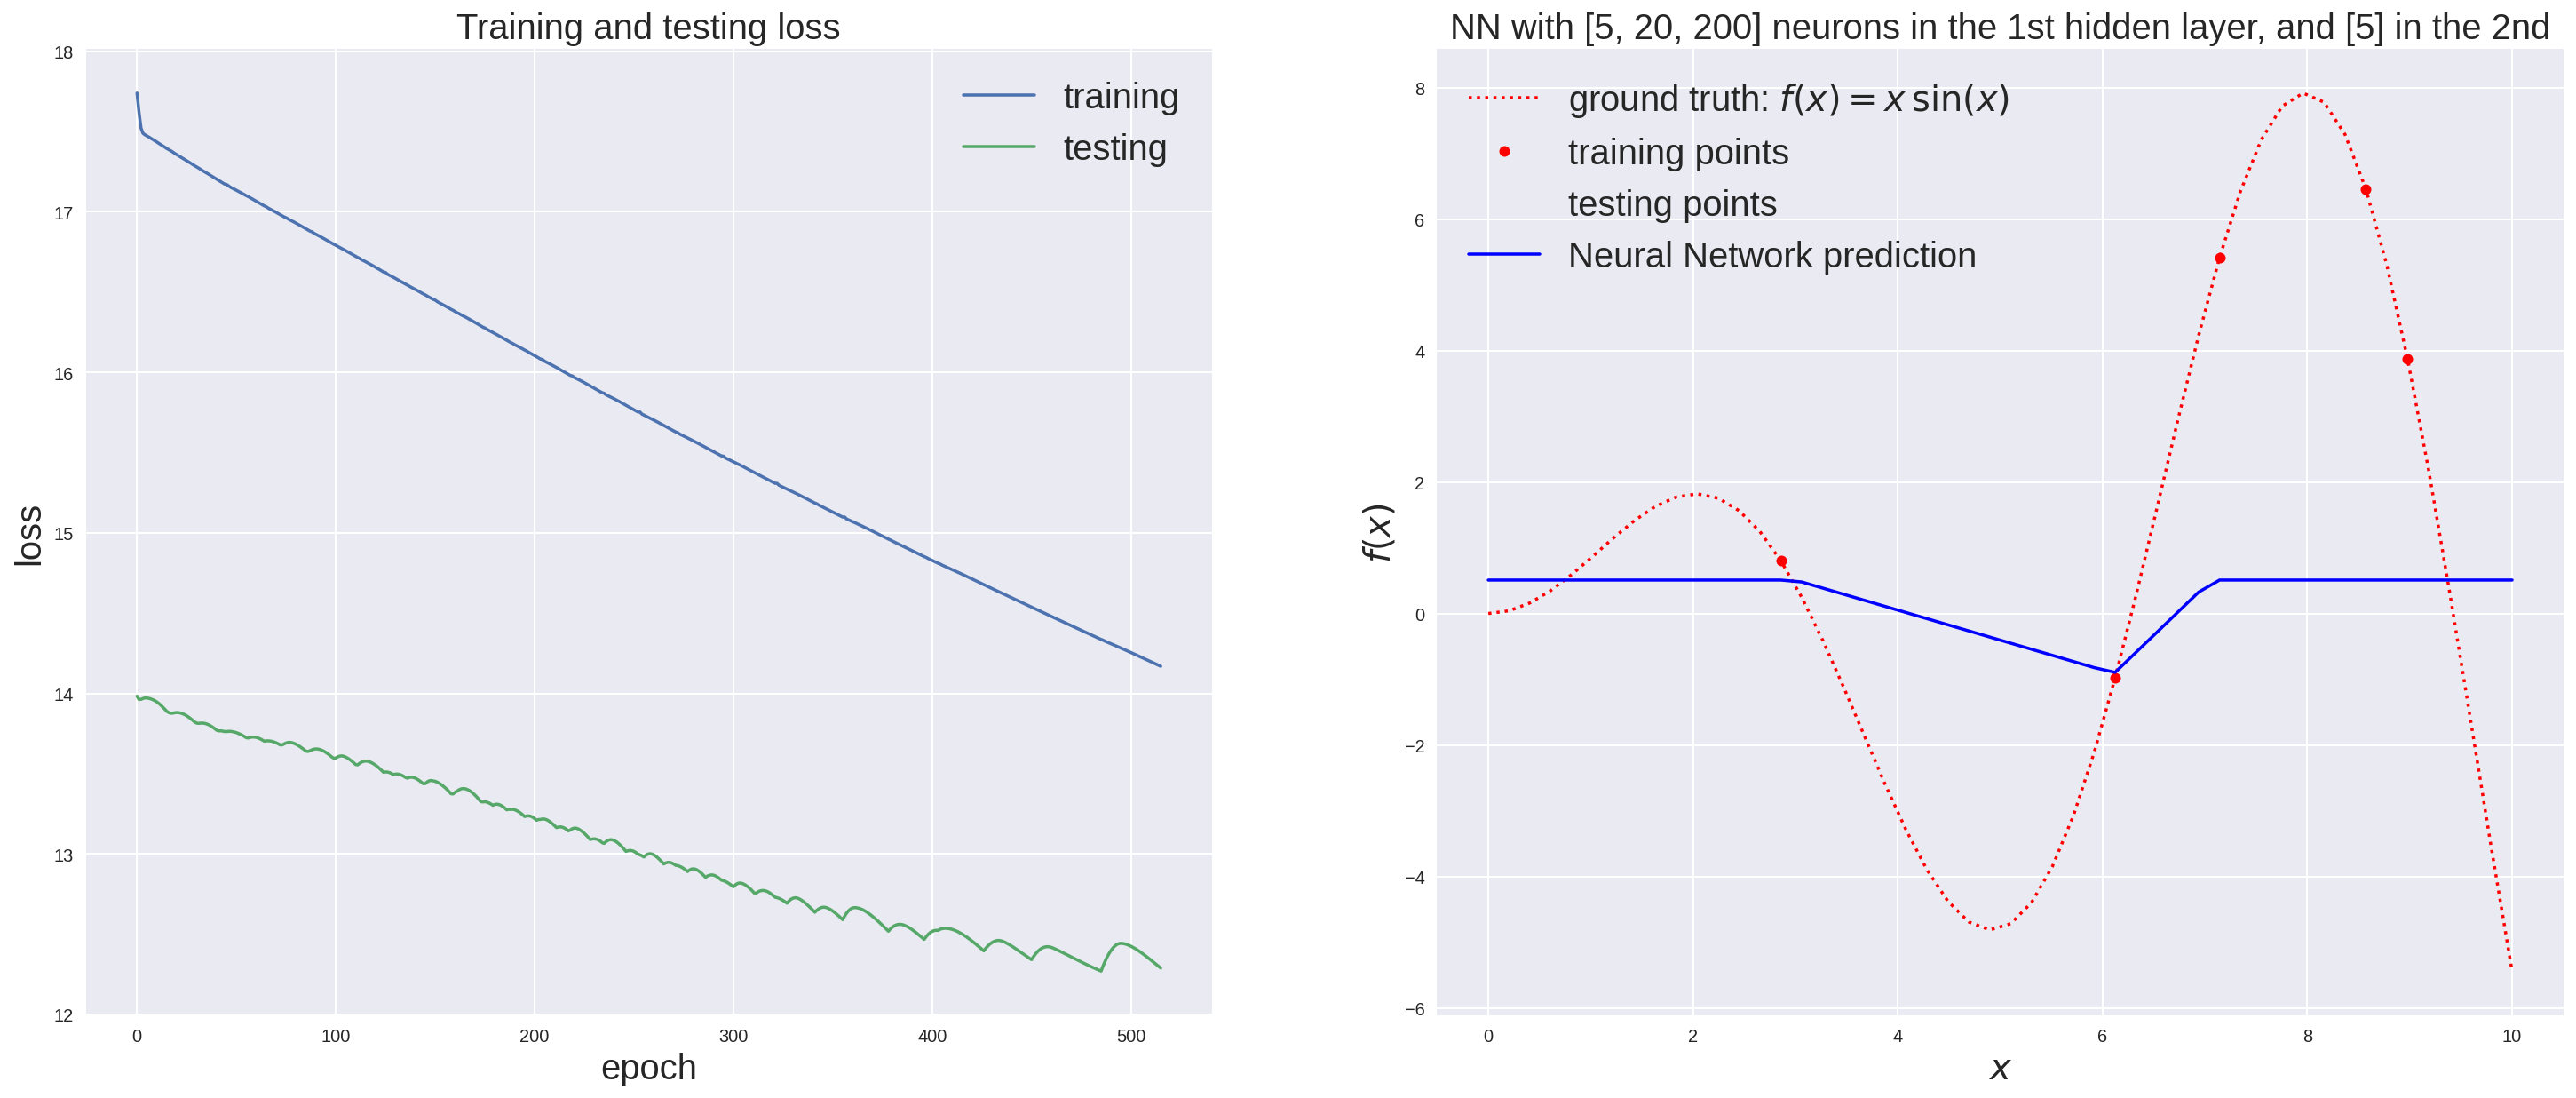

In [17]:
fig_ANN # show figure now.

This neural network approximation is also not brilliant... Were you expecting this?

# <font color='red'>HOMEWORK</font>

Redo the neural network regression but now for the noisy dataset!

In [18]:
# HOMEWORK.

# until here.

### You will explore these and other things in Part 1 of the Midterm Project...

Have fun!

## Solution for Exercise 1

```python
# We start by importing the polynomial predictor from scikit-learn
from sklearn.preprocessing import PolynomialFeatures # For Polynomial fit
from sklearn.linear_model import LinearRegression # For Least Squares
from sklearn.pipeline import make_pipeline # to link different objects

degree = 4 # degree of polynomial we want to fit
poly_model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
poly_model.fit(X_train,y_train) # fit the polynomial to our 5 points in X_train which is a 2D array  
y_poly_pred = poly_model.predict(X_test) # prediction of our polynomial

from sklearn.metrics import mean_squared_error, r2_score # Import error metrics
# Compute MSE and R2 for the GP model
gp_mse_value = mean_squared_error(y_test, y_pred)
gp_r2_value = r2_score(y_test, y_pred)
print('MSE for GPR = ', gp_mse_value)
print('R2 score for GPR = ', gp_r2_value)

# Compute MSE and R2 for the polynomial model
poly_mse_value = mean_squared_error(y_test, y_poly_pred)
poly_r2_value = r2_score(y_test, y_poly_pred)
print('MSE for polynomial = ', poly_mse_value)
print('R2 score for polynomial = ', poly_r2_value)
```

### Solution to Exercise 2

``` python
degree = 4 # degree of polynomial we want to fit
poly_model = make_pipeline(PolynomialFeatures(degree),LinearRegression())
poly_model.fit(X_train,y_noisy_train) # fit the polynomial to our 5 points in X_train which is a 2D array
y_poly_noisy_pred = poly_model.predict(X_test) # prediction of our polynomial

# Compute MSE and R2 for the GP model
# NOTE: here we will compare with the noiseless function (in practice we don't have this information!).
gp_mse_value = mean_squared_error(y_test, y_noisy_pred)
gp_r2_value = r2_score(y_test, y_noisy_pred)
print('MSE for GPR = ', gp_mse_value)
print('R2 score for GPR = ', gp_r2_value)

# Compute MSE and R2 for the polynomial model
poly_mse_value = mean_squared_error(y_test, y_poly_noisy_pred)
poly_r2_value = r2_score(y_test, y_poly_noisy_pred)
print('MSE for polynomial = ', poly_mse_value)
print('R2 score for polynomial = ', poly_r2_value)
```